In [1]:
import seaborn as sns
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
import os
import sys

sns.set_style("white")
sns.set_palette("colorblind")

sys.path.insert(0, '/Users/angela/src/private/bias-in-datasets/active_learning/src')
import Evaluate
from Speedup import get_percent_speedup
from Plotter import format_plot_2ys

OURSYSTEM = "Selective-Backprop (Us)"
BASELINE = "Baseline"
RANDOM = "Random"
BASELINE_COLOR ="#009e73"


In [2]:
class LineResult:
    def __init__(self, line_type, epoch, num_backprop, num_skip, loss, time, acc):
        self.line_type = line_type
        self.epoch = epoch
        self.num_backprop = num_backprop
        self.num_skip = num_skip
        self.loss = loss
        self.time = time
        self.acc = acc

    @property
    def is_train(self):
        return self.line_type == "train_debug"

    @property
    def is_test(self):
        return self.line_type == "test_debug"


def parse_line_v1(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[4])
        time = float(vals[5])
        acc = float(vals[6])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        loss = float(vals[3])
        acc = float(vals[4])
        time = float(vals[5])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, loss, time, acc)


def parse_line_v2(line):
    vals = line.split(',')
    if "train_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[5])
        time = float(vals[6])
        acc = float(vals[7])
        line_type = "train_debug"
    elif "test_debug" in line:
        epoch = int(vals[1])
        num_backprop = int(vals[2])
        num_skipped = int(vals[3])
        loss = float(vals[4])
        acc = float(vals[5])
        time = float(vals[6])
        line_type = "test_debug"
    else:
        return None
    return LineResult(line_type, epoch, num_backprop, num_skipped, loss, time, acc)


def parser_for(filename):
    version = filename.split('_')[-1]
    if version == "v1":
        return parse_line_v1
    if version == "v2":
        return parse_line_v2
    if version == "v3":
        return parse_line_v2
    else:
        Exception("Version cannot be {}".format(version))


def parse_file(filename):
    parser = parser_for(filename)
    with open(filename) as f:
        parsed = [parser(line)
                  for line in f]
    return ([d for d in parsed if d and d.is_train],
            [d for d in parsed if d and d.is_test])



In [3]:
class Config:
    MATCHER = ("^(.*)_(.*)_(.*)_(.*)_(\d+)_(\d*\.?\d*)_(\d*\.?\d*)(_trial\d+)(_seed\d+)?")
    COLORS = {
        "topk-13": "#0072b2",
        "topk-32": "#009e73",
        "topk-64": "#d55e00",
        "topk-96": "#56b4e9",
        "lowk": "#009e73",
        "randomk": "#d55e00",
        "sampling": "#cc79a7",
        "deterministic": "#cc79a7",
        "random": "#56b4e9",
        "Katharopoulos18": "#0072b2",
        "Katharopoulos18-Biased": "#d55e00",
        "Katharopoulos18-Uniform": "#009e73"
    }
    def __init__(self, filename, experiment_name):
        print(filename)

        groups = self.matches(filename)
        self.strategy = groups[0]
        self.dataset = groups[1]
        self.network = groups[2]
        self.top_k = float(groups[3])
        self.batch_size = int(groups[4])
        self.lr = float(groups[5])
        self.decay = groups[6]
        self.seed = None
        self.experiment_name = experiment_name
        unparsed_trial = groups[7]
        self.trial = int(unparsed_trial.strip("_trial"))
        if self.network == "lecunn":
            self.network == "LeNet-5"
        if groups[8]:
            unparsed_seed = groups[8]
            self.seed = int(unparsed_seed.strip("_seed"))
            
    @property
    def label(self):
        if self.strategy == "topk":
            label = "Top {}/{}".format(int(self.top_k),
                                                   self.batch_size)
        elif self.strategy == "lowk":
            label = "Lowest {}/{}".format(int(self.top_k),
                                                     self.batch_size)
        elif self.strategy == "randomk":
            label = "Random {}/{}".format(int(self.top_k),
                                                     self.batch_size)
        elif self.strategy == "sampling" or self.strategy == "deterministic":
            if self.top_k == 1:
                label = "{}".format(BASELINE)
            else:
                label = "{}".format(self.experiment_name) 
        elif self.strategy == "kath":
            label = "{}".format(self.experiment_name)
        elif self.strategy == "baseline":
            label = "{}, {}".format(self.experiment_name,
                                        self.strategy) 
        elif self.strategy == "kuangliu":
            label = "{}, original".format(self.experiment_name) 
        elif self.strategy == "debug":
            label = "{}, debug".format(self.experiment_name) 

        return label
    
    @property
    def color(self):
        if self.experiment_name == RANDOM:
            ckey = "random"
        elif "Kath" in self.experiment_name:
            ckey = self.experiment_name
        elif self.strategy == "topk":
            ckey = "{}-{}".format(self.strategy, int(self.top_k))
        else:
            ckey = self.strategy
        return Config.COLORS[ckey]
            
    def matches(self, filename):
        import re
        return (re.match(Config.MATCHER, filename)).groups()
    
def write_file(plot_file_prefix, show=False):

    plot_file = "{}.pdf".format(plot_file_prefix)
    plt.savefig(plot_file)
    
    print(plot_file)
    
    plot_file = "{}.png".format(plot_file_prefix)
    plt.savefig(plot_file, format="png", dpi=1000)
    
    if show:
        plt.show()
        
    plt.clf()

def format_plot(xlabel, ylabel, label_size=11, grid=False):
    plt.tick_params(axis='y', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='y', which='minor', labelsize=label_size * 1.2)
    plt.tick_params(axis='x', which='major', labelsize=label_size * 1.4)
    plt.tick_params(axis='x', which='minor', labelsize=label_size * 1.2)

    plt.xlabel(xlabel, fontsize=label_size * 1.6)
    plt.ylabel(ylabel, fontsize=label_size * 1.6)
    plt.tight_layout()
    plt.gca().xaxis.grid(grid)
    plt.gca().yaxis.grid(grid)
    
    leg = plt.legend(loc=0, prop={'size': label_size * 1.4})
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2.0)


In [4]:

def plot(xs_by_config,
         ys_by_config,
         xlabel, ylabel,
         plot_dir,
         smoothing=0,
         lw=1,
         ymin=None,
         ymax=None,
         xmax=None,
         ymarker=None,
         annotate_accuracy=False,
         annotate_error=False,
         ylog=False,
         minorticks=False):
    
    fig = plt.figure()
    
    local_xmax = - float("inf")
    local_ymax = - float("inf")
    
    for config, ys in sorted(ys_by_config.iteritems(), key=lambda x: x[0].top_k):
        if len(ys) == 0:
            print "No elements for {} in {}".format(config.label, ylabel)
            continue
            
        xs = xs_by_config[config]

        for i in range(smoothing):
            xs = [(l+r) / 2. for l, r in zip(xs[:-1], xs[1:])]
            ys = [(l+r) / 2. for l, r in zip(ys[:-1], ys[1:])]
        
        #TODO get label here
        label = config.label
        if annotate_accuracy:
            label += ", Acc:{}".format(max(ys))
        if annotate_error:
            label += ", Error:{}".format(min(ys))

        if config.top_k == config.batch_size or config.top_k == 1:
            plt.plot(xs, ys, label=label, linestyle="--", linewidth=lw, alpha=0.7, zorder=0, color=BASELINE_COLOR)
        else:
            plt.plot(xs, ys, label=label, linewidth=lw, alpha=0.9, zorder=0, color=config.color)

        if max(xs) > local_xmax:
            local_xmax = max(xs)
        if max(ys) > local_ymax:
            local_ymax = max(ys)
        if xmax:
            plt.xlim(0, xmax)
        if ymin is not None:
            if ymax is not None:
                plt.ylim(ymin, ymax)
            else:
                plt.ylim(ymin, local_ymax)
        
        # Add visual marker where we achieve ymarker accuracy      
        xmarker = Evaluate.find_first_x_at_y(xs, ys, ymarker)
        if xmarker:
            print("xmarker: ", xmarker)
            plt.scatter([xmarker], [ymarker], marker="*", s=50, color="black", zorder=1)
            
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
    
    if len(ys_by_config.keys()) > 0:
        plot_prefix = "{}/{}_{}_{}_lr{}".format(plot_dir,
                                             config.experiment_name,
                                             xlabel,
                                            ylabel,
                                            config.lr)
    
        format_plot(xlabel, ylabel)
        if ylog:
            ax = fig.add_subplot(1,1,1)
            ax.set_yscale('log')
            if minorticks:            
                ax.get_yaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
                ax.get_yaxis().set_major_formatter(matplotlib.ticker.NullFormatter())
            else:
                ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
                ax.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())
        write_file(plot_prefix, show=True)




In [5]:
def make_instantaneous(l):
    lcopy = l[:]
    lcopy.insert(0, 0)        
    pairs = zip(lcopy[::1], lcopy[1::1])
    ilist = [j - i for i, j in pairs]
    return ilist

def smooth(l, constant):
    for i in range(constant):
        l = [(l+r) / 2. for l, r in zip(l[:-1], l[1:])]
    return l
            
def plot_experiments(experiment_names,
                     experiment_labels,
                     experiments_dir,
                     plot_dir,
                     lrs=None,
                     nets=None,
                     trials=None,
                     strategies=None,
                     sampling_mins=None,
                     smoothing=0,
                     xmax=None,
                     ymin=None,
                     ymax=None,
                     ymarker=None,
                     minorticks=False,
                    extra=False):
    
    train_num_backprops_by_config = {}
    test_num_backprops_by_config = {}
    test_num_inferences_by_config = {}
    train_losses_by_config = {}
    test_losses_by_config = {}
    train_accuracies_by_config = {}
    test_accuracies_by_config = {}
    test_errors_by_config = {}
    train_accuracies_by_config = {}
    ratio_backpropped_by_config_xs = {}
    ratio_backpropped_by_config_ys = {}

    for experiment_name, experiment_label in zip(experiment_names, experiment_labels):
        experiment_dir = os.path.join(experiments_dir, experiment_name)
        for filename in os.listdir(experiment_dir):
            if filename == ".DS_Store" or filename == "pickles" or filename == "sha":
                continue
                
            print(filename)

            filepath = os.path.join(experiment_dir, filename)
            config = Config(filename, experiment_label)
            train_lines, test_lines = parse_file(filepath)
            
            if lrs and config.lr not in lrs:
                continue
            if nets and config.network not in nets:
                continue
            if trials and config.trial not in trials:
                continue
            if sampling_mins and config.top_k not in sampling_mins:
                continue
            if strategies and config.strategy not in strategies:
                continue

            train_num_backprops = [l.num_backprop / float(config.batch_size) for l in train_lines]
            test_num_backprops = [l.num_backprop / float(config.batch_size) for l in test_lines]
            test_num_inferences = [(l.num_backprop + l.num_skip) / float(config.batch_size) for l in test_lines]
            train_num_inferences = [(l.num_backprop + l.num_skip) / float(config.batch_size) for l in train_lines]

            instantaneous_train_num_backprops = make_instantaneous(train_num_backprops)
            instantaneous_train_num_inferences = make_instantaneous(train_num_inferences)

            train_losses = [l.loss for l in train_lines]
            test_losses = [l.loss for l in test_lines]
            train_accuracies = [l.acc for l in train_lines]
            test_accuracies = [l.acc for l in test_lines]
            test_errors = [100-l.acc for l in test_lines]

            ratio_backpropped_xs = []
            ratio_backpropped_ys = []
            
            for tline, b, i in zip(train_lines, instantaneous_train_num_backprops, instantaneous_train_num_inferences):
                if (tline.num_backprop + tline.num_skip) == 0 or (b + i) == 0:
                    continue
                x = tline.num_backprop / float(config.batch_size)
                y = b / (b + i)
                ratio_backpropped_xs.append(x)
                ratio_backpropped_ys.append(y)
            
            ratio_backpropped_xs = smooth(ratio_backpropped_xs, 10)
            ratio_backpropped_ys = smooth(ratio_backpropped_ys, 10)

            train_num_backprops_by_config[config] = train_num_backprops
            test_num_backprops_by_config[config] = test_num_backprops
            test_num_inferences_by_config[config] = test_num_inferences
            train_losses_by_config[config] = train_losses
            test_losses_by_config[config] = test_losses
            train_accuracies_by_config[config] = train_accuracies
            test_accuracies_by_config[config] = test_accuracies
            test_errors_by_config[config] = test_errors
            ratio_backpropped_by_config_xs[config] = ratio_backpropped_xs
            ratio_backpropped_by_config_ys[config] = ratio_backpropped_ys

    if extra:
        plot(ratio_backpropped_by_config_xs, ratio_backpropped_by_config_ys, "Training Iterations", "Ratio Backpropped", plot_dir, smoothing, lw=0.8, ymin=0, xmax=xmax)
        plot(test_num_backprops_by_config, test_accuracies_by_config, "Training Iterations", "Test Accuracy", plot_dir, smoothing, lw=1, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker, annotate_accuracy=True)
        plot(test_num_backprops_by_config, test_losses_by_config, "Training Iterations", "Test Loss", plot_dir, smoothing, lw=1, xmax=xmax)
    plot(test_num_backprops_by_config, test_errors_by_config, "Training Iterations", "Test Error Percent", plot_dir, smoothing, lw=1.5, minorticks=minorticks, ymin=ymin, ymax=ymax, xmax=xmax, ymarker=ymarker, ylog=True, annotate_error=False)


In [6]:
def plot_percent_speedup(plot_dir, nb0s, nb1s, nf1s, labels, max_alpha, current_ratio, estimated_ratio):
    plot_prefix = "{}/cifar10".format(plot_dir)
    
    for nb0, nb1, nf1, label in zip(nb0s, nb1s, nf1s, labels):
        ys = []
        alphas = range(1, max_alpha + 1)
        for alpha in alphas:
            y = get_percent_speedup(nb0, nb1, nf1, alpha)
            ys.append(y)
        plt.plot(alphas, ys, label=label)
    
    plt.axvline(x=current_ratio, color='k', linestyle='--', label="Unoptimized Ratio")
    plt.axvline(x=estimated_ratio, color='k', linestyle=':', label="Estimated Ratio after SW Optimization")

    format_plot("Ratio of Backwards to Forwards Pass Latency", "Percent Speedup")
    write_file(plot_prefix)



In [7]:
def plot_percentiles(plot_dir, files, labels, colors):
    indices = [1, 2]
    ylabels = ["Target Confidence", "Percent Correct"]
    for index, ylabel in zip(indices, ylabels):
        for fname, label, color in zip(files, labels, colors):
            xs = []
            ys = []
            with open(fname) as f:
                for line in f:
                    vals = line.rstrip().split(",")
                    x = float(vals[0])
                    y = float(vals[index])
                    xs.append(x)
                    ys.append(y)
            plt.plot(xs, ys, label=label, color=color)
        format_plot("Percentile", ylabel)
        subplot_dir = os.path.join(plot_dir, ylabel)
        write_file(subplot_dir)
    

deterministic_cifar10_lecunn_0.1_128_0.001_0.0005_trial1_seed1337_v2
deterministic_cifar10_lecunn_0.1_128_0.001_0.0005_trial1_seed1337_v2
deterministic_cifar10_lecunn_1_128_0.001_0.0005_trial1_seed1337_v2
deterministic_cifar10_lecunn_1_128_0.001_0.0005_trial1_seed1337_v2
sampling_cifar10_lecunn_0.1_128_0.001_0.0005_trial1_seed1337_v2
sampling_cifar10_lecunn_0.1_128_0.001_0.0005_trial1_seed1337_v2
sampling_cifar10_lecunn_0_128_0.001_0.0005_trial1_seed1337_v2
sampling_cifar10_lecunn_0_128_0.001_0.0005_trial1_seed1337_v2
sampling_cifar10_lecunn_1_128_0.001_0.0005_trial1_seed1337_v2
sampling_cifar10_lecunn_1_128_0.001_0.0005_trial1_seed1337_v2
../plots/icml18//181230//Selective-Backprop (Us)_Training Iterations_Test Error Percent_lr0.001.pdf


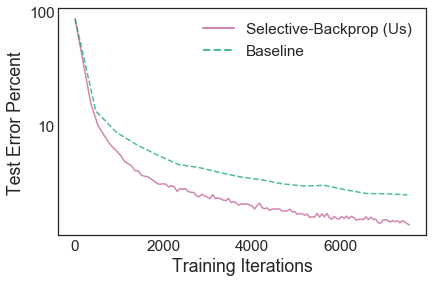

<Figure size 432x288 with 0 Axes>

In [11]:
# MNIST

plot_home_dir = "../plots/icml18/"
experiment_dir = "../data/output/mnist"
baseline_exp = "181230"
baseline_file = "deterministic_cifar10_lecunn_1_128_0.001_0.0005_trial1_seed1337_v2"
do_plot = True
do_evaluate = False

plot_dir = "{}/181230/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = [baseline_exp]

if do_plot:
    plot_experiments(experiment_names,
                     [OURSYSTEM],
                     experiment_dir,
                     plot_dir,
                     trials=[1],
                     sampling_mins = [1.0, 0.1],
                     strategies=["sampling"])

baseline_path = os.path.join(experiment_dir, baseline_exp, baseline_file)
if do_evaluate:
    Evaluate.evaluate(experiment_dir,
                      baseline_exp,
                      baseline_file,
                      baseline_exp)

In [1]:
from scipy import stats

plot_home_dir = "../plots/icml18/"
experiment_dir = "../data/output/cifar10"
networks = [["densenet"], ["mobilenetv2", "mobilenet"], ["resnet"]]
for network in networks:
    plot_dir = "{}/181208_net/{}".format(plot_home_dir, network[0])
    if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)
    
    if "mobilenet" in network:
        plot_experiments(["181208_net", "190120_kathbiased", "181115_seedednew_aug"],
                      [OURSYSTEM, "Katharopoulos18", OURSYSTEM],
                      experiment_dir,
                      plot_dir,
                      nets=network, extra=True)
    else:
        plot_experiments(["181208_net", "181115_seedednew_aug"],
                      [OURSYSTEM, OURSYSTEM],
                      experiment_dir,
                      plot_dir,
                      nets=network)

NameError: name 'os' is not defined

deterministic_cifar100_wideresnet_0.1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar100_wideresnet_0.1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar100_wideresnet_0.1_64_0.0_0.0005_trial2_seed1338_v2
deterministic_cifar100_wideresnet_0.1_64_0.0_0.0005_trial2_seed1338_v2
deterministic_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar100_wideresnet_1_64_0.0_0.0005_trial1_seed1337_v2
../plots/icml18//icml18_lite//Selective-Backprop (Us)_Training Iterations_Test Error Percent_lr0.0.pdf


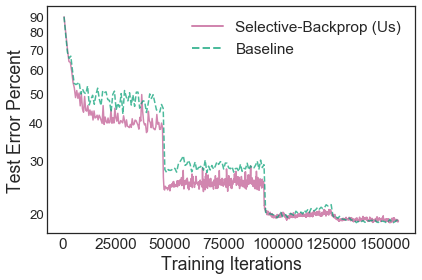

<Figure size 432x288 with 0 Axes>

In [57]:
plot_home_dir = "../plots/icml18/"
experiment_dir = "../data/output/cifar100"
exps = ["icml18_lite"]
do_plot = True

plot_dir = "{}/icml18_lite/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
if do_plot:
    plot_experiments(exps,
                     [OURSYSTEM, OURSYSTEM],
                     experiment_dir,
                     plot_dir,
                     trials=[1],
                     minorticks=True)


sampling_svhn_resnet18_0.1_128_0.01_0.0005_trial1_seed1337_v2
sampling_svhn_resnet18_0.1_128_0.01_0.0005_trial1_seed1337_v2
sampling_svhn_resnet18_1.0_128_0.01_0.0005_trial1_seed1337_v2
sampling_svhn_resnet18_1.0_128_0.01_0.0005_trial1_seed1337_v2
../plots/icml18//190118_giulio//Selective-Backprop (Us)_Training Iterations_Test Error Percent_lr0.01.pdf


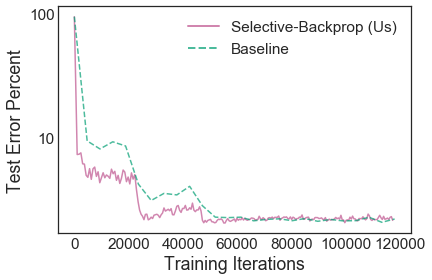

<Figure size 432x288 with 0 Axes>

In [58]:
plot_home_dir = "../plots/icml18/"
experiment_dir = "../data/output/svhn"
exps = ["190118_giulio"]
do_plot = True

plot_dir = "{}/190118_giulio/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
if do_plot:
    plot_experiments(exps,
                     [OURSYSTEM],
                     experiment_dir,
                     plot_dir)

kath_cifar10_mobilenet_1024_128_0.0_0.0005_trial1_seed1337_v2
kath_cifar10_mobilenet_1024_128_0.0_0.0005_trial1_seed1337_v2
kath_cifar10_mobilenet_1024_128_0.0_0.0005_trial1_seed1337_v2
kath_cifar10_mobilenet_1024_128_0.0_0.0005_trial1_seed1337_v2
kath_cifar10_mobilenet_1024_128_0.0_0.0005_trial1_seed1337_v2
kath_cifar10_mobilenet_1024_128_0.0_0.0005_trial1_seed1337_v2
kath_cifar10_resnet_1024_128_0.0_0.0005_trial1_seed1337_v2
kath_cifar10_resnet_1024_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_v2_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_v2_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_v2_1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mob

/usr/local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


../plots/icml18//190120_kath//Katharopoulos18-Uniform_Training Iterations_Test Error Percent_lr0.0.pdf


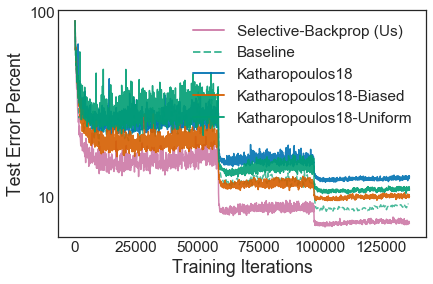

<Figure size 432x288 with 0 Axes>

In [8]:
# Kath18
plot_home_dir = "../plots/icml18/"
experiment_dir = "../data/output/cifar10/"

plot_dir = "{}/190120_kath/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190125_kath","190120_kathuniform", "190120_kathbiased", "181208_net", "181115_seedednew_aug"]

if True:
    plot_experiments(experiment_names,
                     ["Katharopoulos18", "Katharopoulos18-Uniform","Katharopoulos18-Biased", OURSYSTEM],
                     experiment_dir,
                     plot_dir,
                     nets=["mobilenetv2", "mobilenet"])


deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_v2_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_v2_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_v2_1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_v2_1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenetv2_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mo

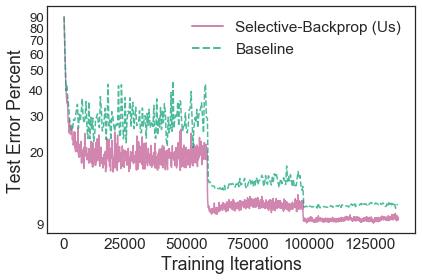






----------------------190116_shuffle0.001--------------------------
deterministic_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
Baseline Error: 11.24
deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
-----------------------------------------------
Final Error: 9.650, 14.146% lower
40.03% fewer backwards and 98.80% more forwards to 11.2% error
New: 7.53 million backwards, 24.95 million forwards
Baseline: 12.55 million backwards, 12.55 million forwards
deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densenet_1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densenet_1_6

<Figure size 432x288 with 0 Axes>

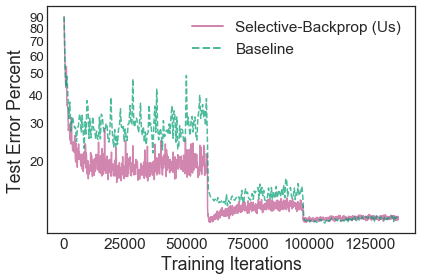






----------------------190116_shuffle0.01--------------------------
deterministic_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
Baseline Error: 11.21
deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
-----------------------------------------------
Final Error: 10.940, 2.409% lower
39.82% fewer backwards and 92.43% more forwards to 11.2% error
New: 7.55 million backwards, 24.15 million forwards
Baseline: 12.55 million backwards, 12.55 million forwards
deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_0.4_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_0.4_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densenet_0.1_64_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_densene

<Figure size 432x288 with 0 Axes>

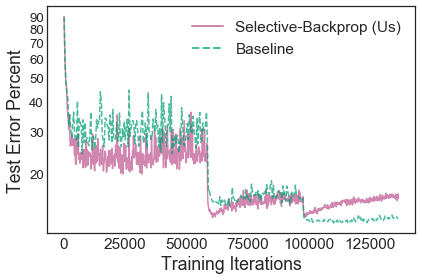






----------------------190116_shuffle0.1--------------------------
deterministic_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2
Baseline Error: 12.93
deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
-----------------------------------------------
Final Error: 15.780, -22.042% lower
SB increases error
deterministic_cifar10_mobilenet_0.4_128_0.0_0.0005_trial1_seed1337_v2
-----------------------------------------------
Final Error: 15.160, -17.247% lower
SB increases error


<Figure size 432x288 with 0 Axes>

In [9]:
# Label error
plot_home_dir = "../plots/icml18/"
experiment_dir = "../data/output/cifar10"

plot_dir = "{}/190116_shuffle/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

a_plot_dir = "{}/{}".format(plot_dir, "0.001")
b_plot_dir = "{}/{}".format(plot_dir, "0.01")
c_plot_dir = "{}/{}".format(plot_dir, "0.1")
plot_dirs = [a_plot_dir, b_plot_dir, c_plot_dir]

experiment_names = ["190116_shuffle0.001", "190116_shuffle0.01", "190116_shuffle0.1"]

for exp_name, pdir in zip(experiment_names, plot_dirs):
    if not os.path.exists(pdir):
        os.makedirs(pdir)
    plot_experiments([exp_name, "181208_net"],
                     [OURSYSTEM, OURSYSTEM],
                     experiment_dir,
                     pdir,
                     nets=["mobilenet"],
                     sampling_mins = [0.1, 1],
                     minorticks=True)
    print "\n\n\n\n"
    print "----------------------{}--------------------------".format(exp_name)
    Evaluate.evaluate(experiment_dir,
                          exp_name,
                          "deterministic_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_v2",
                          exp_name,
                          max_error=20)

deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_v2
lowk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337_v2
lowk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337_v2
randomk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337_v2
randomk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337_v2
topk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337_v2
topk_cifar10_mobilenet_13_128_0.0_0.0005_trial1_seed1337_v2
../plots/icml18//190116_dists//Selective-Backprop (Us)_Training Iterations_Test Error Percent_lr0.0.pdf


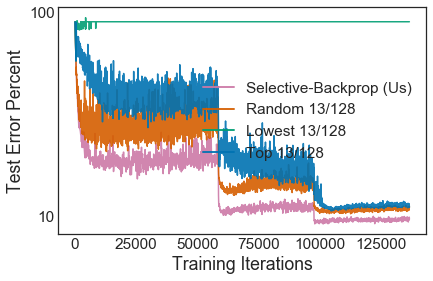

<Figure size 432x288 with 0 Axes>

In [10]:
# Distributions
plot_home_dir = "../plots/icml18/"
experiment_dir = "../data/output/cifar10"

plot_dir = "{}/190116_dists/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
    
experiment_names = ["190116_dists"]

if True:
    plot_experiments(experiment_names,
                     [OURSYSTEM],
                     experiment_dir,
                     plot_dir,
                     nets=["mobilenet"])

In [62]:
plot_dir = "../plots/icml18/speedup"

nb0s = [13.1, 12.6, 19.7]
nb1s = [7.51, 7.53, 7.92]
nf1s = [37.35, 28.4, 53.35]
labels = ["CIFAR10-DenseNet", "CIFAR10-MobilenetV2", "CIFAR10-ResNet18"]

max_alpha = 15
current_ratio = 3
estimated_ratio = 11

plot_percent_speedup(plot_dir, nb0s, nb1s, nf1s, labels, max_alpha, current_ratio, estimated_ratio)

../plots/icml18/speedup/cifar10.pdf


<Figure size 432x288 with 0 Axes>

In [63]:
plot_home_dir = "../plots/icml18/"

exp_name = "190108_confidences"
plot_dir = "{}/{}".format(plot_home_dir, exp_name)
if not os.path.exists(plot_dir):
        os.makedirs(plot_dir)

labels = [OURSYSTEM,
          BASELINE]

prefix = "../plots/batch_stats/190108_confidences/data/"
files = ["{}/{}".format(prefix, "deterministic_cifar10_mobilenet_0.1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch310_4694815backpropped.txt"),
         "{}/{}".format(prefix, "deterministic_cifar10_mobilenet_1_128_0.0_0.0005_trial1_seed1337_target_confidences.pickle_epoch100_5000000backpropped.txt")]
colors = [Config.COLORS["sampling"], BASELINE_COLOR]

plot_percentiles(plot_dir, files, labels, colors)

../plots/icml18//190108_confidences/Target Confidence.pdf
../plots/icml18//190108_confidences/Percent Correct.pdf


<Figure size 432x288 with 0 Axes>

In [ ]:
plot_home_dir = "../plots/icml18/"
experiment_dir = "../data/output/cifar10"
do_plot = True

plot_dir = "{}/181212_topk/".format(plot_home_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)
resnet_plot_dir = "{}/resnet".format(plot_dir)
if not os.path.exists(resnet_plot_dir):
    os.makedirs(resnet_plot_dir)
mobilenet_plot_dir = "{}/mobilenet".format(plot_dir)
if not os.path.exists(mobilenet_plot_dir):
    os.makedirs(mobilenet_plot_dir)
    
experiment_names = ["181212_topk", "181115_seedednew_aug", "181208_net"]

if do_plot:
    plot_experiments(experiment_names,
                     ["TopK", OURSYSTEM, OURSYSTEM],
                     experiment_dir,
                     resnet_plot_dir,
                     nets=["resnet"],
                     trials=[1])
    plot_experiments(experiment_names,
                     ["TopK", OURSYSTEM, OURSYSTEM],
                     experiment_dir,
                     mobilenet_plot_dir,
                     nets=["mobilenet", "mobilenetv2"],
                     trials=[1])

